In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import load_model
import keras.backend as K
tf.compat.v1.disable_eager_execution()

with tf.compat.v1.Session():
    dst_tensor = tf.zeros(shape=(10,10), dtype=tf.float32)

In [2]:
with tf.device('/GPU:0'):
    model_alz = load_model("./AlzDisConvModel.h5")
    model_alz_hyp = load_model("./AlzDisConvModel_hyperTuned.h5")
    model_alz_hyp_rec = load_model("./AlzDisConvModel_hyperTuned_reincarnated.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model_alz.summary()
model_alz_hyp.summary()
model_alz_hyp_rec.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 176, 176, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 44, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123904)           

In [4]:
import os
import cv2
import numpy as np
from pathlib import Path
data_dir = "./Dataset/All"
class_names = os.listdir(data_dir)
data_path = Path(data_dir)

images_dict = {}
images_labels = {}

count = 0
for class_name in class_names:
    images_dict[class_name] = list(data_path.glob(f"{class_name}/*"))
    images_labels[class_name] = count
    count = count + 1

X, y = [], []

for class_name, images in images_dict.items():
    for image in images:
        image_array = cv2.imread(str(image))
        
        # Check if image is successfully read
        if image_array is not None:
            resized_img = cv2.resize(image_array, (176, 176))
            X.append(resized_img)
            y.append(int(images_labels[class_name]))  # Explicitly cast to int
        else:
            print(f"Warning: Unable to read image - {image}")

# Convert lists to numpy arrays
X_test = np.array(X)
y_test = np.array(y, dtype=int)


In [5]:
X_test.shape

(6400, 176, 176, 3)

In [6]:
y_test.shape

(6400,)

In [7]:
y_test

array([0, 0, 0, ..., 3, 3, 3])

In [8]:
with tf.device('/GPU:0'):
    y_pred_probs = model_alz.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

C:\Users\hp\.conda\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [9]:
X_test

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.84734375

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(f"Confusion Matrix:\nTest:\n{cm}")
print(f"Classification Report:\nTest:\n{cr}")

Confusion Matrix:
Test:
[[ 862    2   31    1]
 [   0   64    0    0]
 [   2    1 3196    1]
 [  28   12  899 1301]]
Classification Report:
Test:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       896
           1       0.81      1.00      0.90        64
           2       0.77      1.00      0.87      3200
           3       1.00      0.58      0.73      2240

    accuracy                           0.85      6400
   macro avg       0.89      0.89      0.87      6400
weighted avg       0.88      0.85      0.84      6400



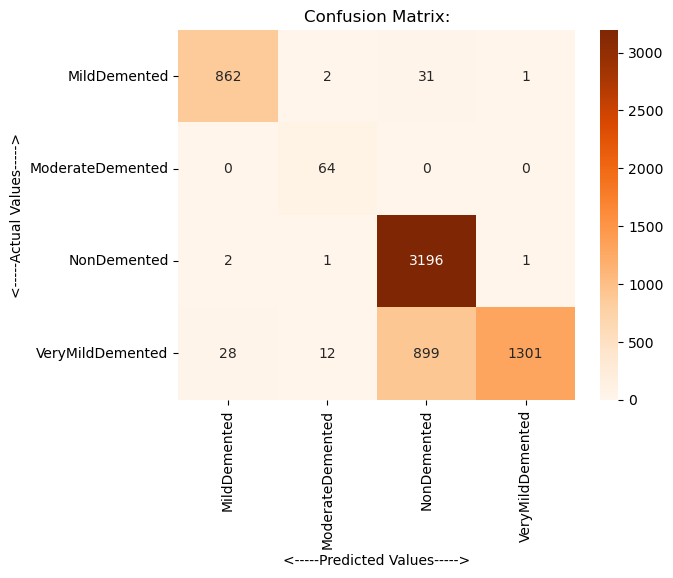

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix:')
plt.xlabel('<-----Predicted Values----->')
plt.ylabel('<-----Actual Values----->')
plt.show()

In [13]:
model_alz.get_weights()

[array([[[[-6.54848963e-02, -4.93786447e-02,  4.65919860e-02,
           -7.34475330e-02, -1.58726901e-01, -9.70140621e-02,
           -1.23305425e-01,  1.21857435e-01, -1.07677011e-02,
           -1.07934931e-02,  3.77973802e-02,  8.31428543e-02,
           -6.98316693e-02, -1.06783882e-01, -7.75584904e-03,
           -1.39806136e-01,  2.97788475e-02,  4.28377390e-02,
           -8.17509964e-02,  2.44675968e-02, -1.30778149e-01,
            5.24811670e-02,  7.56955706e-06, -8.15569535e-02,
           -1.38824880e-01,  2.40625255e-02,  1.08229525e-01,
            3.47825773e-02,  3.86673212e-02, -1.85967749e-03,
            1.15807302e-01,  4.29647565e-02],
          [-1.02501445e-01, -1.00585334e-01, -4.07127887e-02,
            7.76846260e-02, -1.52953818e-01,  1.27165467e-01,
           -7.19330087e-03, -5.65245003e-03,  9.34628919e-02,
           -1.19991638e-01, -7.70048052e-02, -9.66627672e-02,
            1.28537700e-01, -1.47600845e-01,  2.13811807e-02,
            1.16237693e-

In [14]:


with tf.device('/GPU:0'):
    y_pred_hyp_probs = model_alz_hyp.predict(X_test)
    y_pred_hyp = np.argmax(y_pred_hyp_probs, axis=1)



C:\Users\hp\.conda\envs\py310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [15]:
with tf.device('/GPU:0'):
    y_pred_hyp_rec_probs = model_alz_hyp_rec.predict(X_test)
    y_pred_hyp_rec = np.argmax(y_pred_hyp_rec_probs, axis=1)

In [16]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_hyp))

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_hyp_rec)


0.98609375


0.9

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, y_pred_hyp)
cr = classification_report(y_test, y_pred_hyp)
print(f"Confusion Matrix:\nTest:\n{cm}")
print(f"Classification Report:\nTest:\n{cr}")

Confusion Matrix:
Test:
[[ 878    0   10    8]
 [   0   64    0    0]
 [   0    0 3174   26]
 [   9    0   36 2195]]
Classification Report:
Test:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       896
           1       1.00      1.00      1.00        64
           2       0.99      0.99      0.99      3200
           3       0.98      0.98      0.98      2240

    accuracy                           0.99      6400
   macro avg       0.99      0.99      0.99      6400
weighted avg       0.99      0.99      0.99      6400



In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, y_pred_hyp_rec)
cr = classification_report(y_test, y_pred_hyp_rec)
print(f"Confusion Matrix:\nTest:\n{cm}")
print(f"Classification Report:\nTest:\n{cr}")

Confusion Matrix:
Test:
[[ 733    0    5  158]
 [   0   64    0    0]
 [   0    1 2724  475]
 [   0    0    1 2239]]
Classification Report:
Test:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       896
           1       0.98      1.00      0.99        64
           2       1.00      0.85      0.92      3200
           3       0.78      1.00      0.88      2240

    accuracy                           0.90      6400
   macro avg       0.94      0.92      0.92      6400
weighted avg       0.92      0.90      0.90      6400



In [19]:
model_alz_hyp.get_weights()

[array([[[[-1.19736753e-01, -5.40246777e-02, -2.34753881e-02, ...,
            9.93338153e-02, -1.11241572e-01, -2.11149501e-03],
          [-7.48953447e-02,  3.20457201e-03, -8.19305629e-02, ...,
            1.01144470e-01,  8.18585381e-02,  1.35898264e-02],
          [ 4.46993522e-02, -5.18337600e-02,  2.60481257e-02, ...,
           -8.80653784e-02,  7.68762603e-02, -7.73703381e-02]],
 
         [[ 7.52356276e-02,  2.48406865e-02,  9.55396369e-02, ...,
           -7.81612843e-02, -8.50330442e-02,  2.29044945e-05],
          [ 8.07895735e-02, -2.64697615e-03, -1.13779746e-01, ...,
           -6.03631847e-02,  8.46990496e-02,  1.84359942e-02],
          [ 8.95490572e-02,  4.51722629e-02, -7.85743371e-02, ...,
           -8.62895697e-02, -5.43592833e-02,  8.22233781e-03]],
 
         [[ 6.04983307e-02,  8.11305717e-02,  3.02456971e-02, ...,
            1.07857674e-01, -4.91350368e-02, -9.71006528e-02],
          [ 1.04633108e-01, -1.29346959e-02, -3.51384953e-02, ...,
            1.342

In [20]:
model_alz_hyp_rec.get_weights()

[array([[[[ 0.10038636, -0.08319499, -0.09685425, ..., -0.07863315,
            0.02954498, -0.0025981 ],
          [ 0.11498437, -0.11402162,  0.02061198, ..., -0.10469247,
            0.08861281,  0.02943515],
          [ 0.02037459, -0.10947368,  0.07499068, ..., -0.02644422,
           -0.03416302,  0.06174865]],
 
         [[ 0.05390531, -0.00251259,  0.01106717, ..., -0.00718565,
           -0.0529141 ,  0.06619976],
          [-0.08991075,  0.08175473,  0.09710174, ..., -0.00646635,
           -0.08832331, -0.00800966],
          [-0.02112903,  0.04659476,  0.07307412, ...,  0.10399538,
           -0.05300969,  0.06918381]],
 
         [[-0.10400143, -0.01894308, -0.02430044, ..., -0.11453111,
           -0.10596128,  0.04582498],
          [ 0.00039112,  0.06019471, -0.00804939, ..., -0.05411579,
           -0.10411949,  0.03395242],
          [-0.08042333,  0.09258136, -0.03392009, ..., -0.12309499,
            0.10914521,  0.06144175]],
 
         [[-0.00573367,  0.08396574, 